In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import os
from joblib import load
from tabulate import tabulate
import sys
sys.path.append('..')
from utils import get_meta_data

In [2]:
BASE_PATH = '/home/amir/code/tree_exp/'

In [3]:
dataset_names = np.array(['ionosphere', 'wdbc', 'breast-w', 'diabetes', 'qsar-biodeg',
           'banknote-authentication', 'spambase', 'kdd_ipums_la_97-small',
           'phoneme', 'eye_movements', 'pol', 'MagicTelescope', 'house_16H',
           'electricity', 'MiniBooNE', 'covertype', 'Higgs', 'steel-plates-fault', 
                     'blood-transfusion-service-center', 'mozilla4'])
dataset_names_alt = np.array(['Ionosphere', 'WDBC', 'Wisconsin', 'Diabetes', 'Qsar-Biodeg',
           'Banknote Auth', 'Spambase', 'KDD IPUMS (Small)',
           'Phoneme', 'Eye Movements', 'Pol', 'Magic Telescope', 'House 16H',
           'Electricity', 'MiniBooNE', 'Covertype', 'Higgs', 'Steel Plates Fault', 
                     'Blood Transfusion', 'Mozilla4'])

exp_names = ['lime', 'kernel_shap', 'lpi', 'tree_shap_obs', 'tree_shap_inter', 'local_mdi', 'saabas', 'global', 'random']
exp_names_alt = ['LIME', 'SHAP', 'LPI', 'TSHAP (O)', 'TSHAP (I)', 'LocalMDI', 'Saabas',  'Global', 'Random']

In [4]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)

    return ax

def get_auc(result):
    cutoffs = np.linspace(0.05, 0.5, 10)
    temp = np.array(result).mean(axis=0)
    auc_ = 0
    for k in range(1, len(cutoffs) - 1):
        x = cutoffs[k] - cutoffs[k - 1]
        y = temp[k] + temp[k-1]
        auc = y / ( 2 * x)
    
    return auc

In [5]:
def get_rank_robust_with_size(m_name, s_size, measure_name):
    robust_vals = pickle.load( open( "./robust_vals_sample_{}.p".format(m_name), "rb" ) )
    result = {}
    result_sample = []
    
    for i in range(len(dataset_names)):
        for j in range(len(exp_names)): 
            result_sample.append(get_auc(robust_vals[s]['abs'][measure_name][dataset_names[i]][exp_names[j]]))
    
    result_sample = np.array(result_sample)
    sample_eval = pd.DataFrame(result_sample.reshape(len(dataset_names), len(exp_names)))
    sample_eval.index = dataset_names_alt
    sample_eval.columns=exp_names_alt
    sample_eval = sample_eval.sort_index()
    
    if measure_name == 'insertion':
        ranked_sample_eval = sample_eval.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_sample_eval = sample_eval.rank(ascending=False, axis=1)
    return ranked_sample_eval

def get_rank_robust_with_mean(m_name, measure_name):
    robust_vals = pickle.load( open( "./robust_vals_{}_all_v2.p".format(m_name), "rb" ) )
    result = []
    for i in range(len(dataset_names)):
        for j in range(len(exp_names)): 
            result.append(get_auc(robust_vals['abs'][measure_name][dataset_names[i]][exp_names[j]]))
    result = np.array(result)
    
    result_df = pd.DataFrame(result.reshape(len(dataset_names), len(exp_names)), index=dataset_names, columns=exp_names).round(2)
    result_df.index = dataset_names_alt
    result_df.columns=exp_names_alt
    
    result_df = result_df.sort_index()

    if measure_name == 'insertion':
        ranked_result = result_df.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_result = result_df.rank(ascending=False, axis=1)
    return ranked_result

In [6]:
colors = {
    'lime': 'red', 
    'kernel_shap': 'blue', 
    'lpi':'green', 
    'tree_shap_obs': 'magenta', 
    'tree_shap_inter': 'darkgoldenrod', 
    'local_mdi': 'brown', 
    'saabas': 'orange', 
    'global': 'gray',
    'random': 'black'
}

m_name = 'rf'
robust_vals_ = pickle.load( open( "./robust_vals_{}_all.p".format(m_name), "rb" ) )
robust_vals_g = pickle.load( open( "./robust_vals_{}_global.p".format(m_name), "rb" ) )
pickle.dump( temp, open(  "./robust_vals_{}_all_v2.p".format(m_name), "wb" ) )

def merge(a: dict, b: dict, path=[]):
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] != b[key]:
                raise Exception('Conflict at ' + '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a
pickle.dump( temp, open(  "./robust_vals_{}_all_v2.p".format(m_name), "wb" ) )

In [11]:
m_name = 'rf'
robust_vals = pickle.load( open( "./robust_vals_{}_all_v2.p".format(m_name), "rb" ) )
#robust_vals = pickle.load( open( "./robust_vals_sample_{}.p".format(m_name), "rb" ) )
result = {}
#s_size = 50
measure_name = 'insertion'

result_sample = []

for i in range(len(dataset_names)):
    for j in range(len(exp_names)): 
        #result_sample.append(get_auc(robust_vals[s_size]['abs'][measure_name][dataset_names[i]][exp_names[j]]))
        result_sample.append(get_auc(robust_vals['abs'][measure_name][dataset_names[i]][exp_names[j]]))
result_sample = np.array(result_sample)
sample_eval = pd.DataFrame(result_sample.reshape(len(dataset_names), len(exp_names))).round(2)
sample_eval.index = dataset_names_alt
sample_eval.columns=exp_names_alt
sample_eval = sample_eval.sort_index()
sample_eval.loc['Average'] = sample_eval.mean().round(2)


In [12]:
sample_eval

LIME  SHAP   LPI  TSHAP (O)  TSHAP (I)  LocalMDI  Saabas  \
Banknote Auth       2.93  1.42  1.25       1.77       2.08      1.71    1.80   
Blood Transfusion   3.40  2.35  2.41       2.88       2.82      2.83    2.55   
Covertype           4.56  0.76  0.87       1.90       1.81      0.64    0.85   
Diabetes            2.43  1.98  1.95       2.39       2.24      2.47    2.19   
Electricity         4.20  3.31  2.90       3.55       3.70      3.29    3.50   
Eye Movements       2.05  1.31  1.59       1.66       1.63      2.24    1.47   
Higgs               1.43  1.15  1.17       1.21       1.27      2.05    1.34   
House 16H           2.70  2.23  1.92       2.71       2.52      2.72    2.31   
Ionosphere          2.77  2.38  2.51       2.42       2.54      2.25    2.26   
KDD IPUMS (Small)   4.17  1.61  2.52       1.94       1.90      2.03    1.67   
Magic Telescope     4.46  4.12  3.60       4.27       4.56      4.51    4.36   
MiniBooNE           2.88  1.40  1.42       1.91       1.97      2.08    1.62   
Mozilla4            5.90  1.45  2.13       1.73       1.71      1.47    1.40   
Phoneme             5.46  3.63  3.93       4.33       5.21      4.45    4.40   
Pol                 2.54  0.46  0.61       0.39       0.34      0.58    0.34   
Qsar-Biodeg         2.96  1.54  1.81       2.16       2.18      1.93    1.61   
Spambase            3.36  0.73  2.79       1.41       1.30      1.06    0.82   
Steel Plates Fault  2.87  2.01  1.35       3.01       3.06      2.13    1.93   
WDBC                1.81  1.09  0.79       1.76       1.48      0.99    1.07   
Wisconsin           3.26  1.92  2.52       2.76       2.65      2.82    2.72   
Average             3.31  1.84  2.00       2.31       2.35      2.21    2.01   

                    Global  Random  
Banknote Auth         2.81    6.28  
Blood Transfusion     3.47    3.45  
Covertype             0.94    4.57  
Diabetes              2.32    3.26  
Electricity           3.74    5.32  
Eye Movements         2.52    2.73  
Higgs                 1.30    3.17  
House 16H             2.76    4.69  
Ionosphere            2.23    5.04  
KDD IPUMS (Small)     1.93    5.26  
Magic Telescope       4.07    6.62  
MiniBooNE             1.78    3.86  
Mozilla4              1.30    5.60  
Phoneme               5.43    5.61  
Pol                   0.44    6.71  
Qsar-Biodeg           2.31    4.06  
Spambase              1.10    4.82  
Steel Plates Fault    2.56    6.18  
WDBC                  1.01    4.96  
Wisconsin             2.96    4.42  
Average               2.35    4.83

In [13]:
if measure_name == 'insertion':
    tmp = sample_eval.style.highlight_min(axis=1)
else:
    tmp = sample_eval.style.highlight_max(axis=1)
tmp


In [14]:
print(tabulate(sample_eval, tablefmt='latex_raw', headers= exp_names_alt))

\begin{tabular}{lrrrrrrrrr}
\hline
                    &   LIME &   SHAP &   LPI &   TSHAP (O) &   TSHAP (I) &   LocalMDI &   Saabas &   Global &   Random \\
\hline
 Banknote Auth      &   2.93 &   1.42 &  1.25 &        1.77 &        2.08 &       1.71 &     1.8  &     2.81 &     6.28 \\
 Blood Transfusion  &   3.4  &   2.35 &  2.41 &        2.88 &        2.82 &       2.83 &     2.55 &     3.47 &     3.45 \\
 Covertype          &   4.56 &   0.76 &  0.87 &        1.9  &        1.81 &       0.64 &     0.85 &     0.94 &     4.57 \\
 Diabetes           &   2.43 &   1.98 &  1.95 &        2.39 &        2.24 &       2.47 &     2.19 &     2.32 &     3.26 \\
 Electricity        &   4.2  &   3.31 &  2.9  &        3.55 &        3.7  &       3.29 &     3.5  &     3.74 &     5.32 \\
 Eye Movements      &   2.05 &   1.31 &  1.59 &        1.66 &        1.63 &       2.24 &     1.47 &     2.52 &     2.73 \\
 Higgs              &   1.43 &   1.15 &  1.17 &        1.21 &        1.27 &       2.05 &     1.34

In [15]:
if measure_name == 'insertion':
        ranked_sample_eval = sample_eval.rank(ascending=True, axis=1)
elif measure_name == 'deletion': 
    ranked_sample_eval = sample_eval.rank(ascending=False, axis=1)
#sns.boxplot(ranked_sample_eval, ax=ax[k])

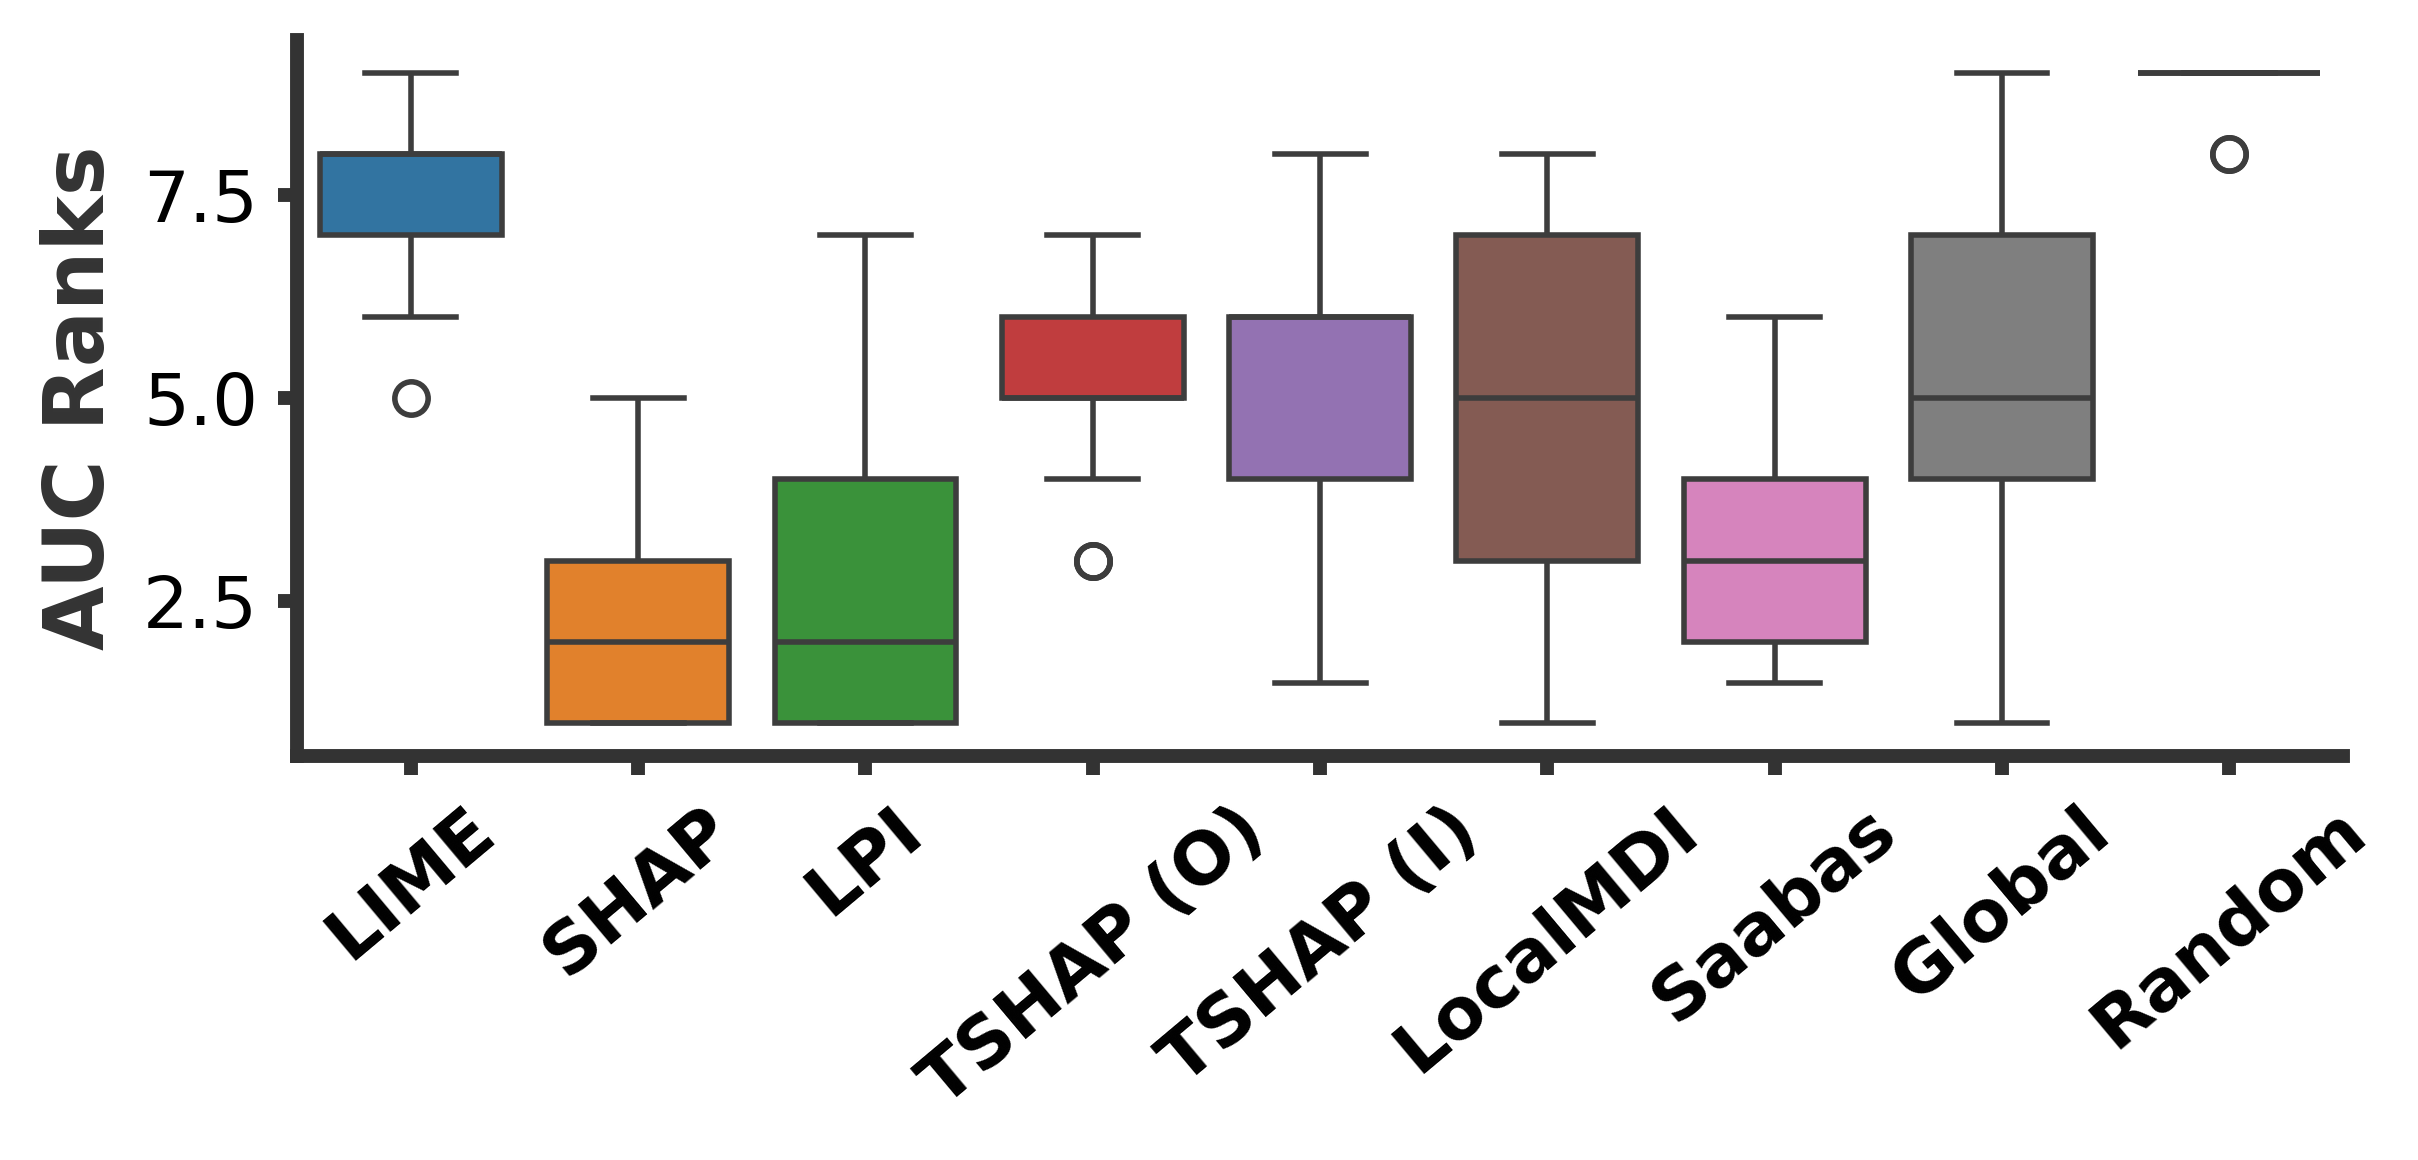

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=400)
palette = colors.values()
sns.boxplot(ranked_sample_eval, ax=ax)
ax.set_xticks(np.arange(len(exp_names)))
ax.set_ylabel('AUC Ranks')
ax.set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')
ax = process_ax(ax)
plt.tight_layout()

#plt.savefig('../figs/boxplot_{}_{}_sample_50.pdf'.format(m_name, measure_name))


### Sample Size effect

In [9]:
ranked_df_

1     10    20    50
LIME       4.00  4.50  4.50  4.50
SHAP      -7.00 -6.00 -6.00 -6.00
LPI       -4.00 -4.75 -4.75 -4.75
TSHAP (O)  1.75  1.00  1.75  1.50
TSHAP (I)  0.00 -0.50 -0.25 -0.25
LocalMDI  -3.00 -2.50 -3.50 -2.50
Saabas    -4.00 -3.00 -3.00 -3.00
Global     2.00  2.00  2.50  3.00
Random     8.00  8.00  8.00  8.00

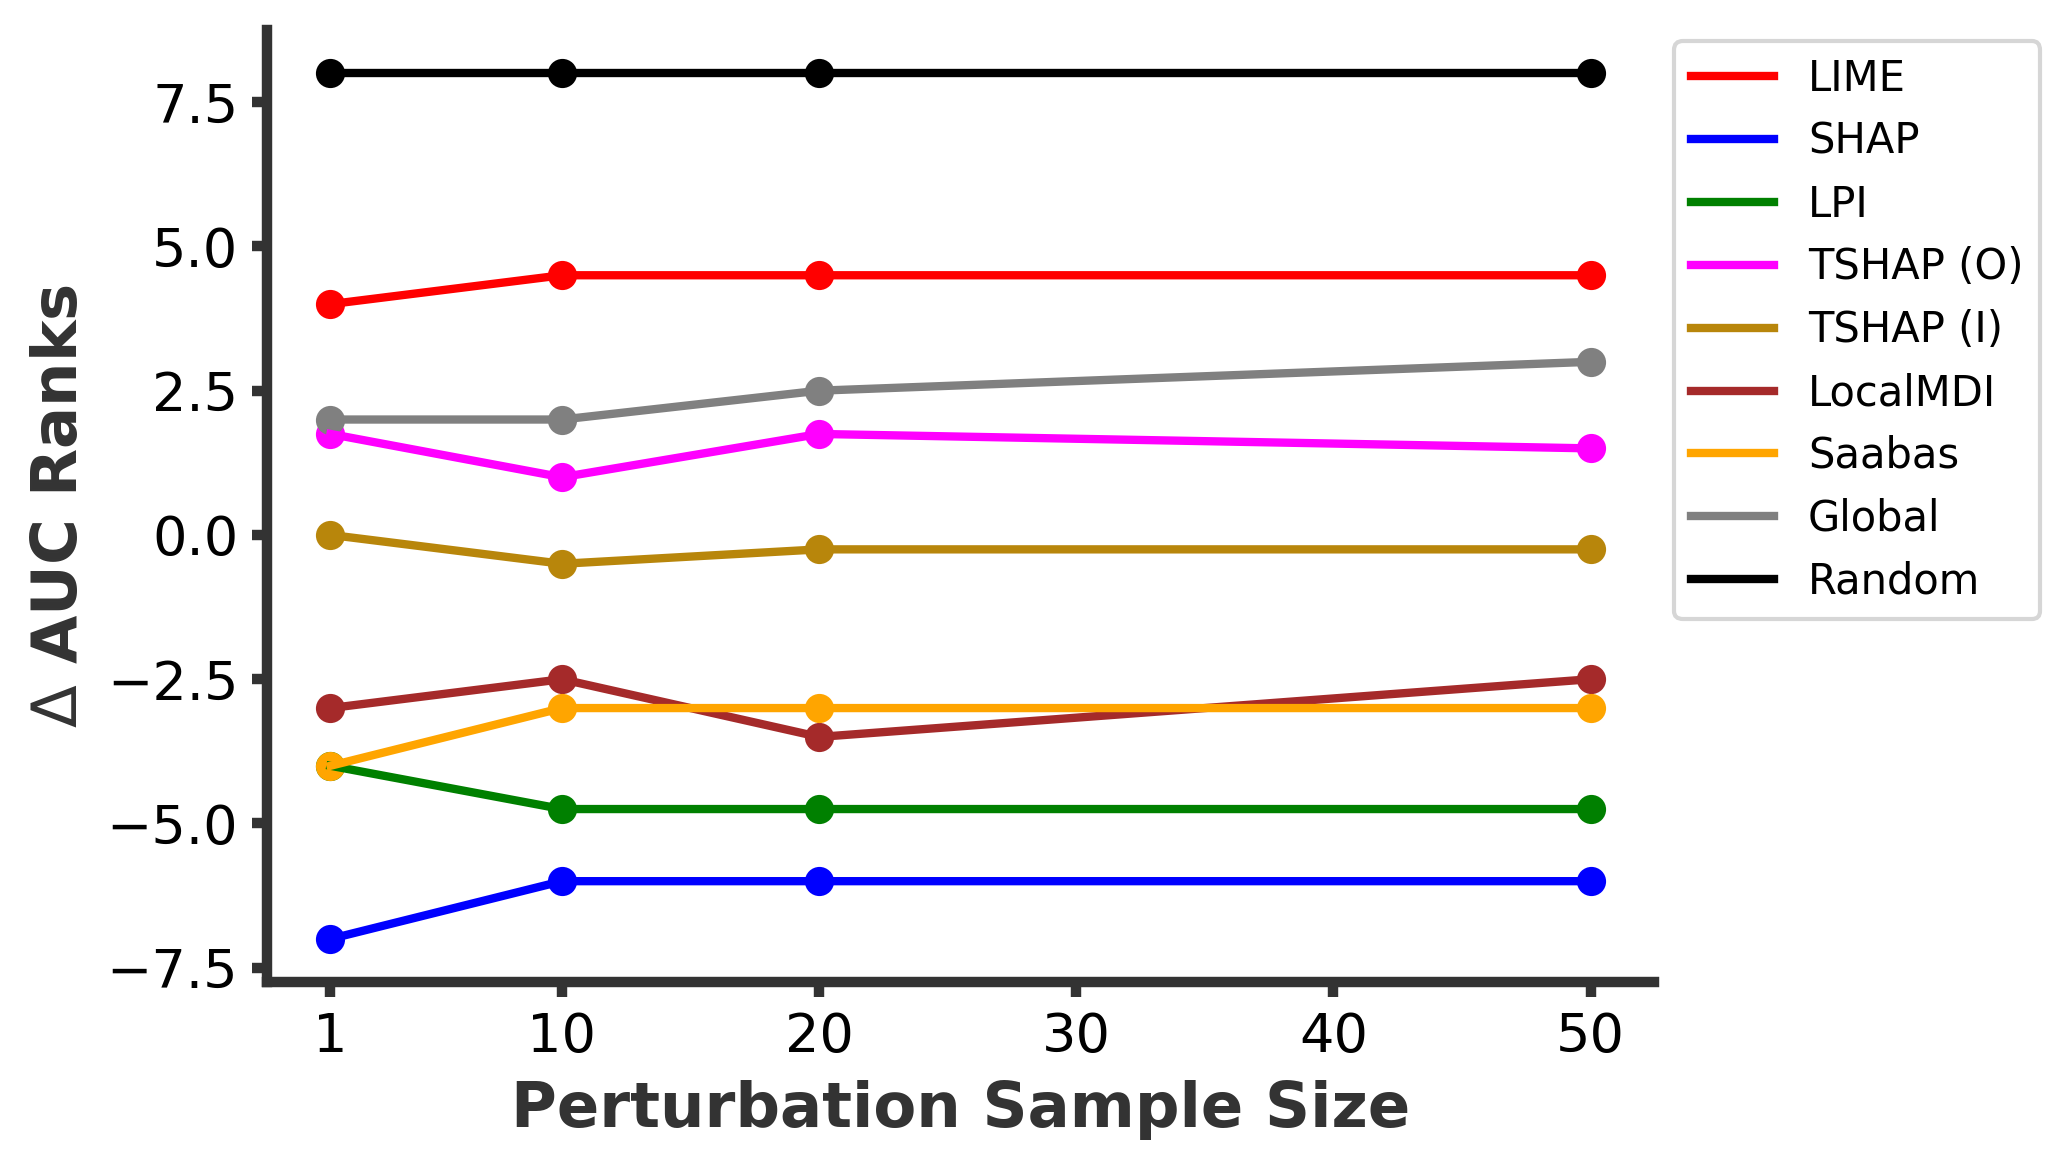

In [7]:
m_name = 'rf'
#robust_vals = pickle.load( open( "./robust_vals_{}_all_v2.p".format(m_name), "rb" ) )
#robust_vals = pickle.load( open( "./robust_vals_sample_{}.p".format(m_name), "rb" ) )
result = {}
s_size = [1, 10, 20, 50]

measure_name = 'deletion'
ranked_ = []

for k in range(len(s_size)):
    s = s_size[k]

    eval_s = get_rank_robust_with_size(m_name, s, measure_name)
    
    if measure_name == 'insertion':
        ranked_eval_1 = eval_s.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_eval_1 = eval_s.rank(ascending=False, axis=1)
    
    eval_mean = get_rank_robust_with_mean(m_name, measure_name)
    
    if measure_name == 'insertion':
        ranked_eval_mean = eval_mean.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_eval_mean = eval_mean.rank(ascending=False, axis=1)

    diff = eval_s - ranked_eval_mean
    
    ranked_.append(diff.median().values)

ranked_df_= pd.DataFrame(ranked_).T
ranked_df_.columns = s_size
ranked_df_.index = exp_names_alt

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)
for i in range(ranked_df_.shape[0]): 
    plt.plot(s_size, ranked_df_.iloc[i], label=ranked_df_.index[i], color=list(colors.values())[i], lw=2)
    plt.scatter(s_size, ranked_df_.iloc[i],  color=list(colors.values())[i])
    ax.set_xticks([1, 10, 20, 30, 40, 50])
    ax.set_xticklabels([1, 10, 20, 30, 40, 50])

ax.legend(bbox_to_anchor=(1, 1.01), fontsize=10)
ax.set_xlabel('Perturbation Sample Size')
ax.set_ylabel(r'$\Delta$ AUC Ranks')

ax = process_ax(ax)


plt.tight_layout()
plt.savefig('../figs/bplot_diff_rank_{}_{}.pdf'.format(m_name, measure_name))

NameError: name 'palette' is not defined

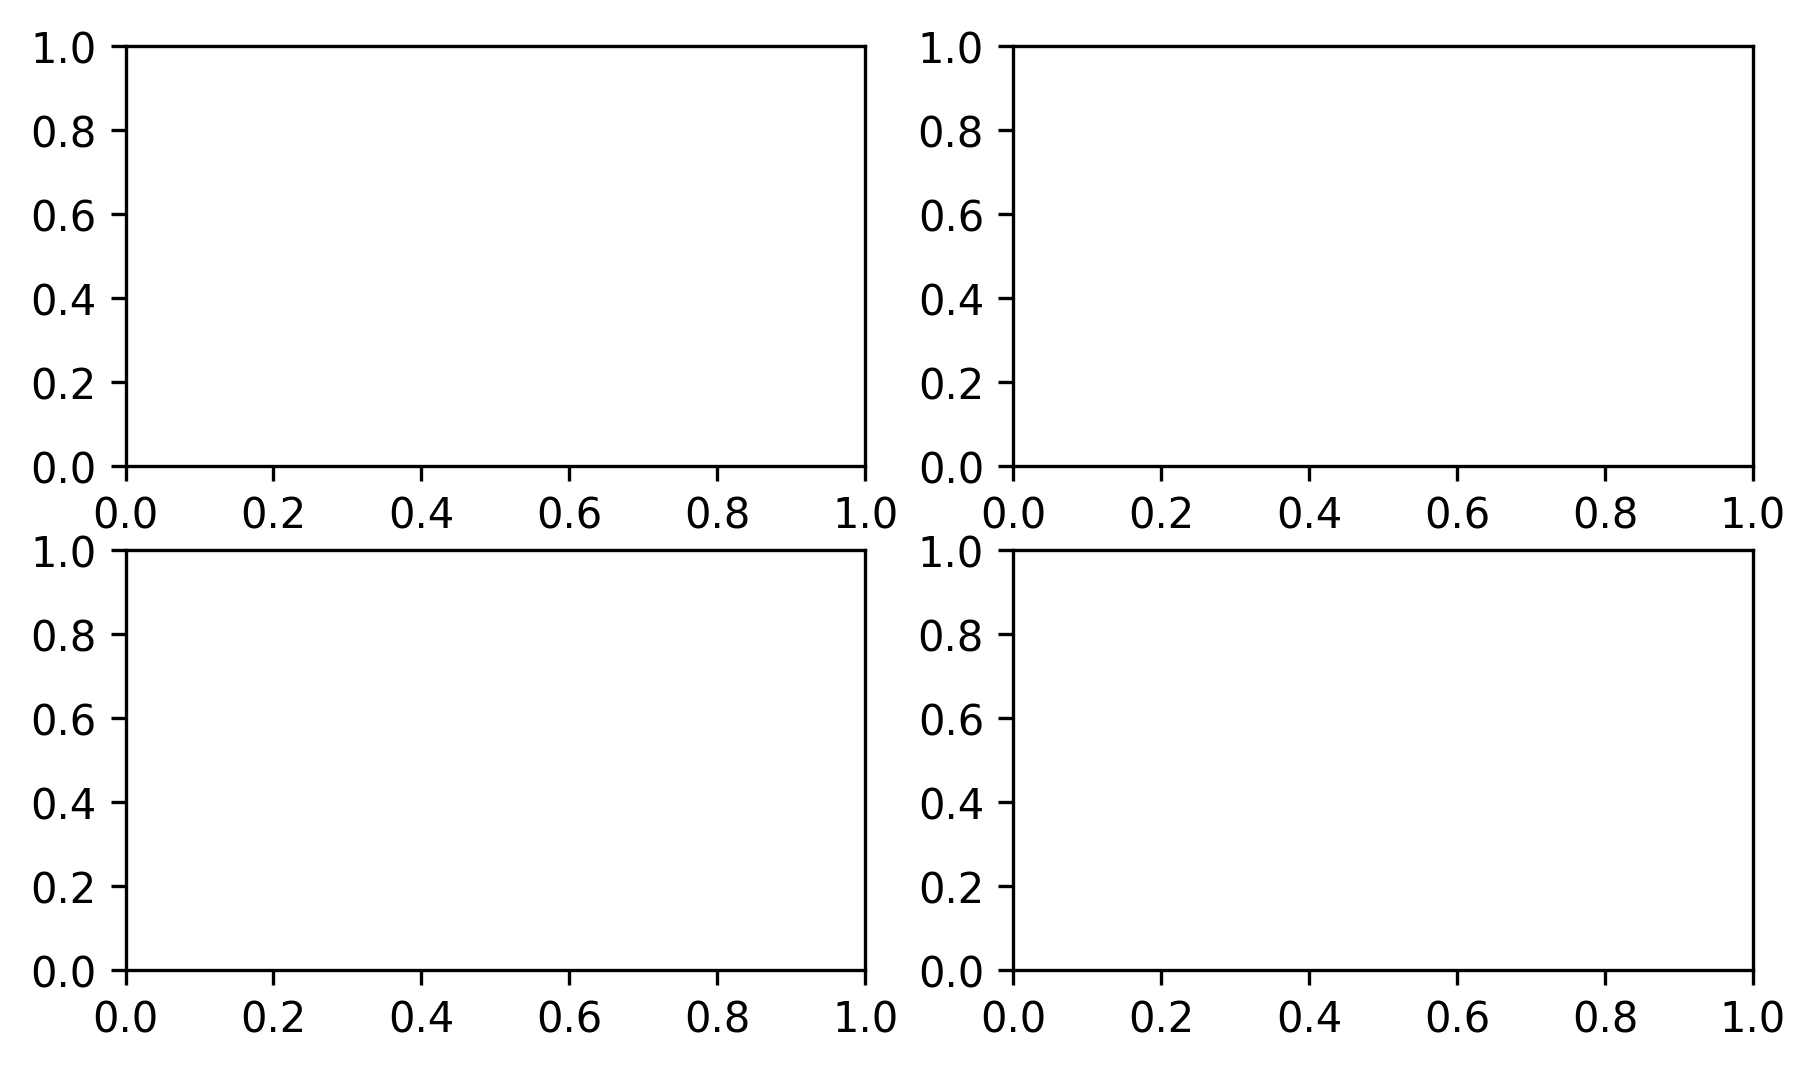

In [10]:
m_name = 'rf'
#robust_vals = pickle.load( open( "./robust_vals_{}_all_v2.p".format(m_name), "rb" ) )
robust_vals = pickle.load( open( "./robust_vals_sample_{}.p".format(m_name), "rb" ) )
result = {}
s_size = [1, 10, 20, 50]

measure_name = 'deletion'
ranked_ = []
fig, ax = plt.subplots(2, 2, figsize=(7, 4), dpi=300)
ax = ax.ravel()
for k in range(len(s_size)):
    s = s_size[k]

    eval_s = get_rank_robust_with_size(m_name, s, measure_name)
    
    if measure_name == 'insertion':
        ranked_eval_1 = eval_s.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_eval_1 = eval_s.rank(ascending=False, axis=1)
    
    eval_mean = get_rank_robust_with_mean(m_name, measure_name)
    
    if measure_name == 'insertion':
        ranked_eval_mean = eval_mean.rank(ascending=True, axis=1)
    elif measure_name == 'deletion': 
        ranked_eval_mean = eval_mean.rank(ascending=False, axis=1)

    diff = eval_s - ranked_eval_mean
    
    ranked_.append(diff.median().values)

    sns.boxplot(diff, ax=ax[k], palette=palette, medianprops=dict(color="white"))
    ax[k].set_xticks(np.arange(len(exp_names_alt)))
    ax[k].set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')


'''ranked_df_= pd.DataFrame(ranked_).T
ranked_df_.columns = s_size
ranked_df_.index = exp_names_alt

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=300)
for i in range(ranked_df_.shape[0]): 
    plt.plot(s_size, ranked_df_.iloc[i], label=ranked_df_.index[i], color=list(colors.values())[i], lw=2)
    plt.scatter(s_size, ranked_df_.iloc[i],  color=list(colors.values())[i])
    ax.set_xticks([1, 10, 20, 30, 40, 50])
    ax.set_xticklabels([1, 10, 20, 30, 40, 50])

ax.legend(bbox_to_anchor=(1, 1.01), fontsize=10)
ax.set_xlabel('Perturbation Sample Size')
ax.set_ylabel(r'$\Delta$ AUC Ranks')

ax = process_ax(ax)


plt.tight_layout()
plt.savefig('../figs/bplot_diff_rank_{}_{}.pdf'.format(m_name, measure_name))'''

ranked_eval_gb_insertion = get_rank_robust_with_size('gb', 50, 'insertion')
ranked_eval_gb_insertion_mean = get_rank_robust_with_mean('gb', 'insertion')

ranked_eval_rf_insertion = get_rank_robust_with_size('rf', 50, 'insertion')
ranked_eval_rf_insertion_mean = get_rank_robust_with_mean('rf', 'insertion')

ranked_eval_gb_deletion = get_rank_robust_with_size('gb', 50, 'deletion')
ranked_eval_gb_deletion_mean = get_rank_robust_with_mean('gb','deletion')

ranked_eval_rf_deletion = get_rank_robust_with_size('rf', 50, 'deletion')
ranked_eval_rf_deletion_mean = get_rank_robust_with_mean('rf', 'deletion')

fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True, dpi=300)
ax = ax.ravel()
palette = colors.values()

sns.boxplot(ranked_eval_gb_insertion - ranked_eval_gb_insertion_mean, ax=ax[0], palette=palette, medianprops=dict(color="white"))
ax[0].set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')

sns.boxplot(ranked_eval_gb_deletion - ranked_eval_gb_deletion_mean, ax=ax[1], palette=palette, medianprops=dict(color="white"))
ax[1].set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')

sns.boxplot(ranked_eval_rf_insertion - ranked_eval_rf_insertion_mean, ax=ax[2], palette=palette, medianprops=dict(color="white"))
ax[2].set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')

sns.boxplot(ranked_eval_rf_deletion - ranked_eval_rf_deletion_mean, ax=ax[3], palette=palette, medianprops=dict(color="white"))
ax[3].set_xticklabels(exp_names_alt, rotation=40, fontweight='bold')

for i in range(4):
    ax[i] = process_ax(ax[i])
plt.show()

In [199]:
meta = get_meta_data()
meta.index = dataset_names_alt
meta = meta.sort_index()

In [200]:
total_df = pd.concat([result_df, meta], axis=1)

In [201]:
total_df

lime  kernel_shap   lpi  tree_shap_obs  tree_shap_inter  \
Banknote Auth       2.59         1.13  0.61           1.04             1.50   
Blood Transfusion   2.49         1.98  1.88           1.98             1.84   
Covertype           2.65         0.08  0.21           0.06             0.05   
Diabetes            2.98         2.22  2.11           2.58             2.28   
Electricity         2.01         1.07  0.94           1.28             1.15   
Eye Movements       0.99         0.72  0.88           0.74             0.71   
Higgs               0.83         0.47  0.25           0.36             0.40   
House 16H           1.87         1.36  1.18           1.28             1.39   
Ionosphere          2.01         0.26  0.51           0.61             0.43   
KDD IPUMS (Small)   6.39         0.61  2.27           0.78             0.67   
Magic Telescope     2.91         3.18  1.68           2.99             2.82   
MiniBooNE           1.76         0.38  0.22           0.56             0.39   
Mozilla4            4.70         0.42  0.44           0.36             0.49   
Phoneme             3.92         3.40  3.35           3.72             3.37   
Pol                 0.49         0.06  0.00           0.01             0.00   
Qsar-Biodeg         2.44         0.94  0.99           1.00             1.00   
Spambase            5.00         0.10  0.94           0.14             0.15   
Steel Plates Fault  0.00         0.00  0.00           0.00             0.00   
WDBC                0.41         0.12  0.05           0.17             0.16   
Wisconsin           2.63         0.55  0.54           1.42             0.81   

                    local_mdi  saabas  global  random  Training Size  \
Banknote Auth            1.55    1.52    2.90    4.63            919   
Blood Transfusion        2.41    2.30    2.44    2.70            501   
Covertype                0.06    0.05    0.13    4.38          13400   
Diabetes                 2.86    2.67    3.00    4.31            514   
Electricity              2.63    1.66    0.90    5.52          30359   
Eye Movements            0.85    0.83    0.71    2.90           7327   
Higgs                    0.60    0.61    0.38    3.82          13400   
House 16H                1.66    1.78    1.80    4.53          15265   
Ionosphere               0.62    0.70    0.71    5.12            235   
KDD IPUMS (Small)        0.86    0.85    0.92    5.15           3475   
Magic Telescope          3.65    2.78    2.64    5.77          12743   
MiniBooNE                0.57    0.62    0.53    3.14          13400   
Mozilla4                 3.40    0.59    0.49    3.33          10415   
Phoneme                  4.57    3.98    4.12    4.96           3620   
Pol                      0.00    0.00    0.01    5.87          10050   
Qsar-Biodeg              1.77    1.35    1.61    4.44            706   
Spambase                 0.20    0.24    0.24    5.56           3082   
Steel Plates Fault       0.00    0.01    0.00    6.54           1300   
WDBC                     0.23    0.53    0.22    3.90            381   
Wisconsin                2.40    2.27    1.50    4.02            468   

                    Test Size  Features    GB    RF  
Banknote Auth             453         4  0.98  0.98  
Blood Transfusion         247         4  0.79  0.79  
Covertype                6600        54  0.78  0.86  
Diabetes                  254         8  0.74  0.76  
Electricity             14953         7  0.83  0.88  
Eye Movements            3609        24  0.72  0.73  
Higgs                    6600        28  0.71  0.72  
House 16H                7519        16  0.88  0.90  
Ionosphere                116        34  0.90  0.92  
KDD IPUMS (Small)        1713        20  0.89  0.88  
Magic Telescope          6277        10  0.87  0.88  
MiniBooNE                6600        50  0.93  0.93  
Mozilla4                 5130         4  0.94  0.95  
Phoneme                  1784         5  0.86  0.90  
Pol                      4950        

In [202]:
total_corr = total_df.corr(method='pearson').loc[:, ['Training Size', 'Test Size', 'Features', m_name.upper()]]

In [203]:
total_corr = total_corr.iloc[:7, :]
total_corr

Training Size  Test Size  Features        GB
lime                 -0.119959  -0.119898 -0.209509  0.029151
kernel_shap           0.003887   0.003921 -0.633594 -0.324338
lpi                  -0.151861  -0.151800 -0.518850 -0.329463
tree_shap_obs        -0.057199  -0.057164 -0.654375 -0.303053
tree_shap_inter      -0.038337  -0.038303 -0.680248 -0.287778
local_mdi             0.088861   0.088892 -0.785654 -0.183575
saabas               -0.078046  -0.078014 -0.718946 -0.261724

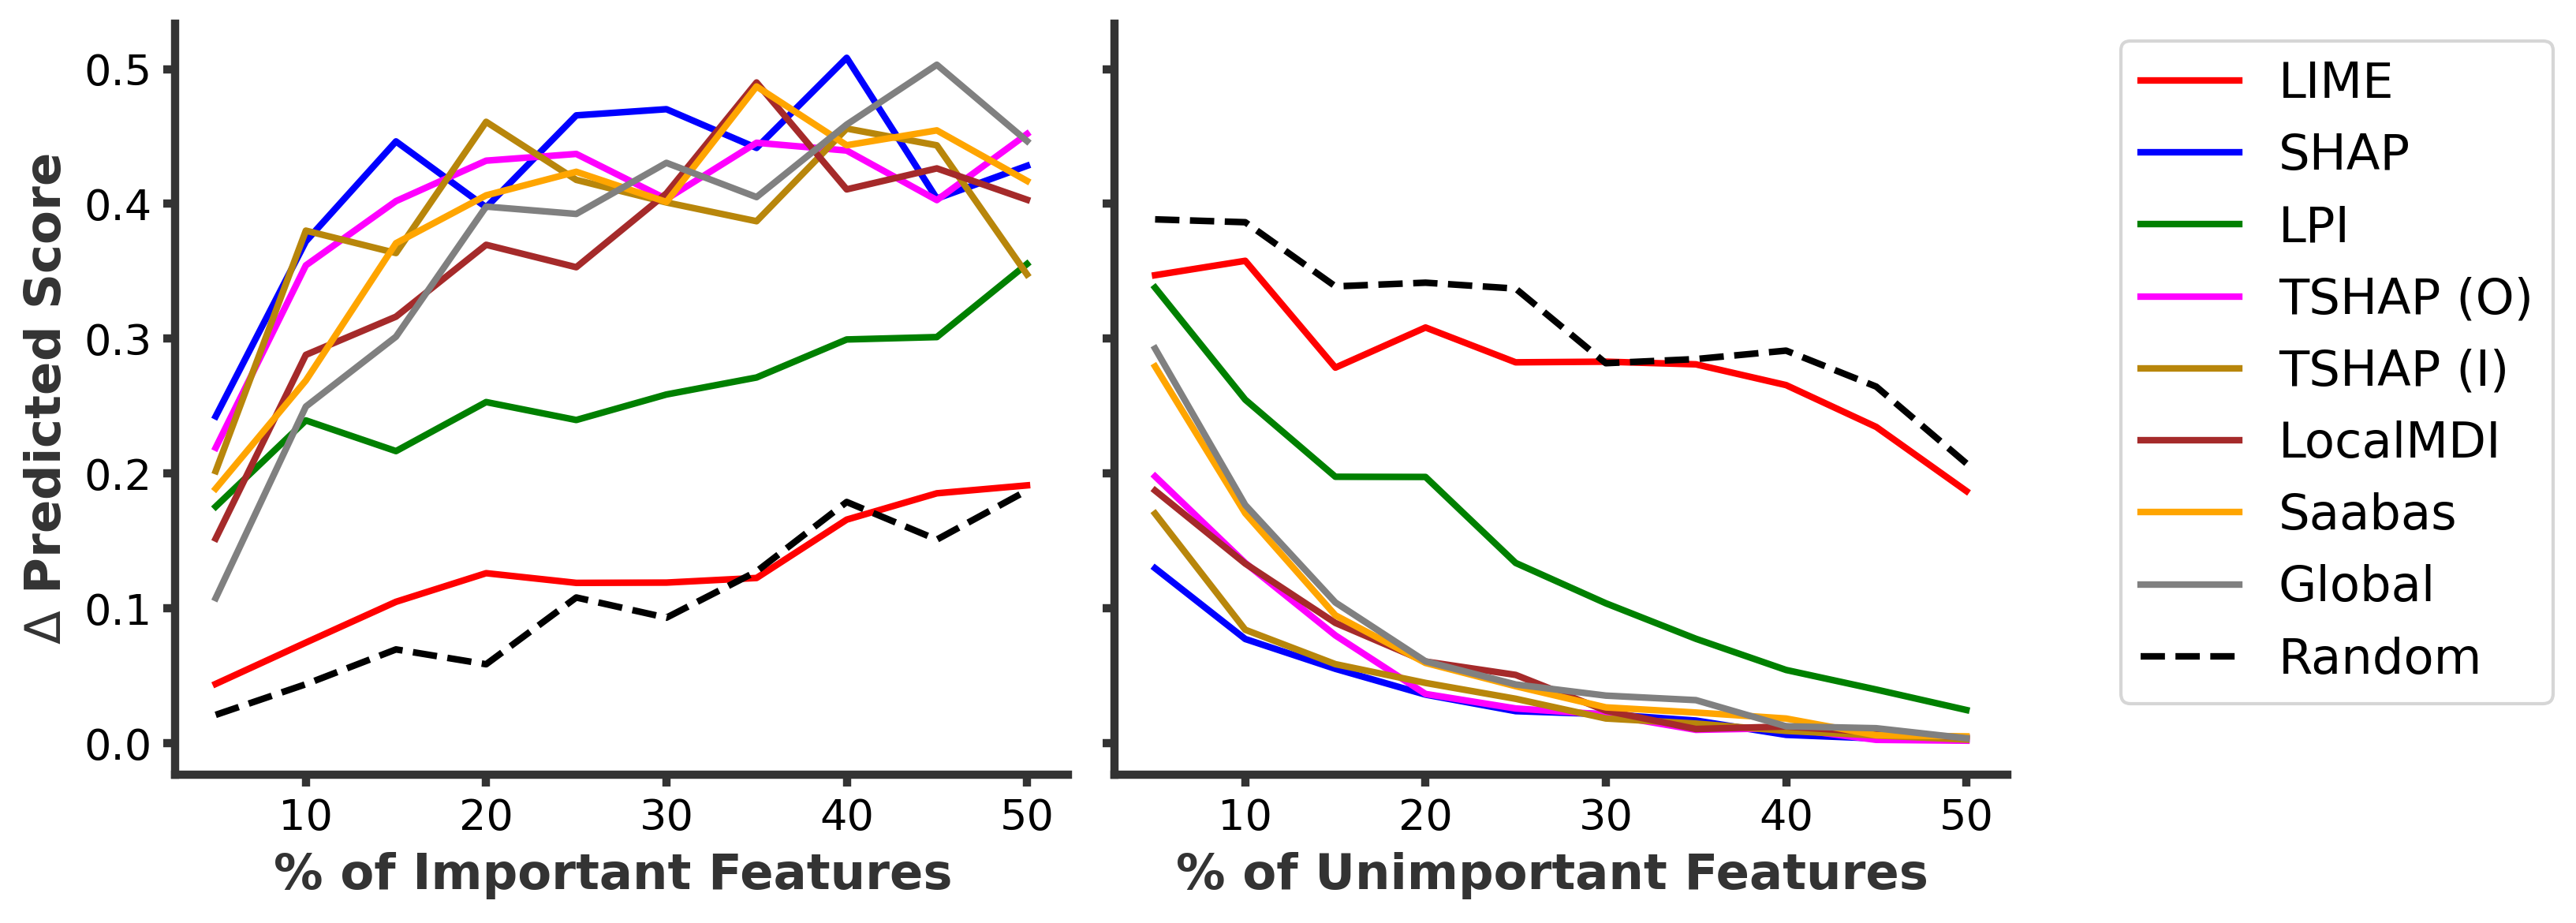

In [25]:
m_name = 'rf'
d_name = 'spambase'
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True, dpi=300)
cutoffs = np.linspace(0.05, 0.5, 10)

for i in range(len(exp_names)): 
    if exp_names[i] == 'random':
        linestyle = '--'
    else:
        linestyle = '-'
        
    y_value_del = np.array(robust_vals['abs']['deletion'][d_name][exp_names[i]]).mean(axis=0)
    ax[0].plot(cutoffs * 100, y_value_del, label = exp_names_alt[i], linestyle=linestyle, c=colors[exp_names[i]], lw=2)

    y_value_ins = np.array(robust_vals['abs']['insertion'][d_name][exp_names[i]]).mean(axis=0)
    ax[1].plot(cutoffs * 100, y_value_ins, label = exp_names_alt[i], linestyle=linestyle, c=colors[exp_names[i]], lw=2)

    
ax[1].legend(bbox_to_anchor=(1.1, 1.01), fontsize=15)
ax[0].set_xlabel('% of Important Features ') 
ax[0] = process_ax(ax[0])
ax[1] = process_ax(ax[1])
ax[1].set_xlabel('% of Unimportant Features ') 
ax[0].set_ylabel(r'$\Delta$ Predicted Score')

plt.tight_layout()
plt.savefig('../figs/importance_by_preturb_{}_{}.pdf'.format(m_name, d_name))
plt.show()

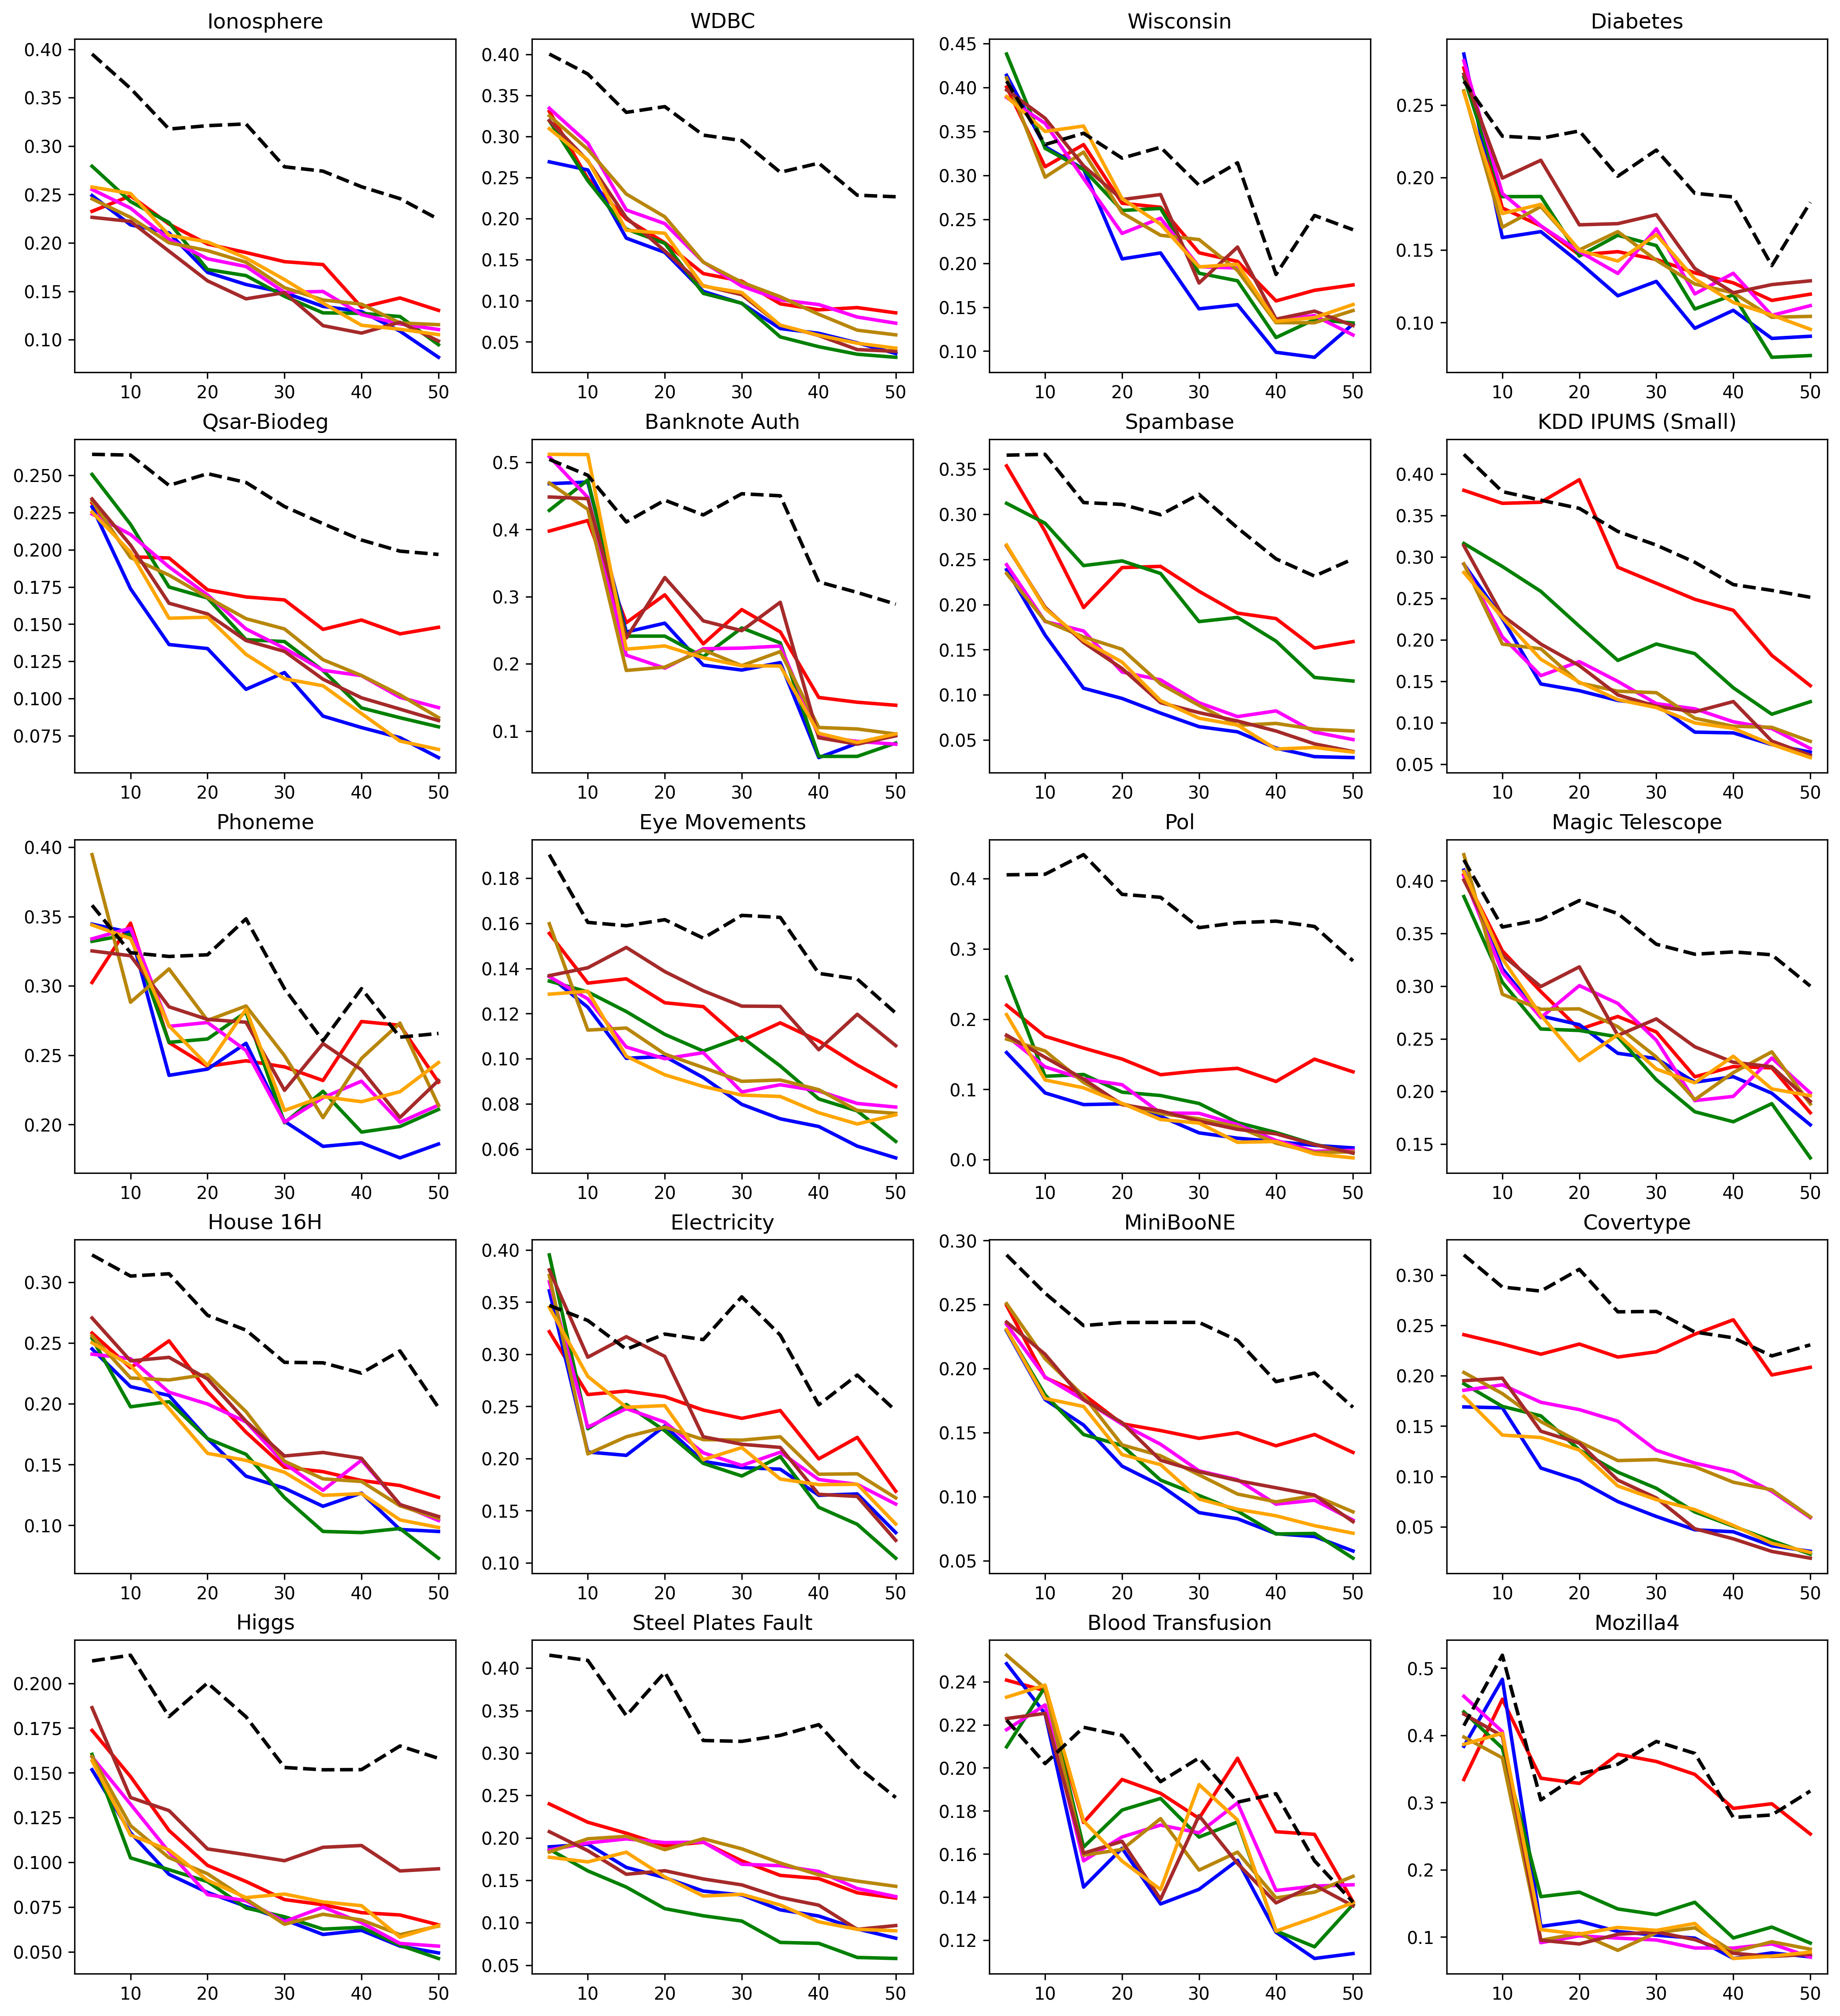

In [51]:
fig, ax = plt.subplots(5, 4, figsize=(18, 20), dpi=300)
cutoffs = np.linspace(0.05, 0.5, 10)
ax = ax.ravel()
measure_name = 'insertion'

for j in range(len(dataset_names)):
    d_name = dataset_names[j]
    for i in range(len(exp_names)): 
        if exp_names[i] == 'random':
            linestyle = '--'
        else:
            linestyle = '-'
            
        y_value_del = np.array(robust_vals['abs'][measure_name][d_name][exp_names[i]]).mean(axis=0)
        ax[j].plot(cutoffs * 100, y_value_del, label = exp_names_alt[i], linestyle=linestyle, c=colors[exp_names[i]], lw=2)
        ax[j].set_title(dataset_names_alt[j])
        '''y_value_ins = np.array(robust_vals['abs']['insertion'][d_name][exp_names[i]]).mean(axis=0)
        ax[j].plot(cutoffs * 100, y_value_ins, label = exp_names_alt[i], linestyle=linestyle, c=colors[exp_names[i]], lw=2)'''

    
#ax[1].legend(bbox_to_anchor=(1.1, 1.01), fontsize=15)
#ax[0].set_xlabel('% of Important Features ') 
#ax[0] = process_ax(ax[0])
#ax[1] = process_ax(ax[1])
#ax[1].set_xlabel('% of Unimportant Features ') 
#ax[0].set_ylabel(r'$\Delta$ Predicted Score')

#plt.tight_layout()
#plt.savefig('../figs/importance_by_preturb_{}_{}.pdf'.format(m_name, d_name))
plt.show()

<BarContainer object of 48 artists>

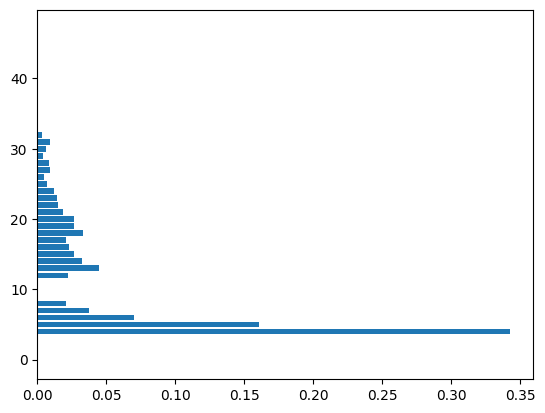

In [55]:
m_path = f'{BASE_PATH}/models/default'
model = load(f'{m_path}/{d_name}/{m_name}.joblib')
plt.barh(np.arange(len(model.feature_importances_)), model.feature_importances_)

# Test 

In [280]:
def get_robustness_sample(explanation, instance_explained, train_data, 
                          model, type_robust, selection_type='abs', sample_size=20):    
    cutoffs = np.linspace(0.05, 0.5, 10)
    instance_explained = instance_explained.reshape(1, -1)
    explained_class = model.predict(instance_explained)[0]
    base_pred = model.predict_proba(instance_explained)[0][explained_class]
    
    robust_result = []
    for cutoff in cutoffs:
        threshold = int(np.round(cutoff * explanation.shape[0]))
        
        if selection_type == 'abs': 
            feat_selected = np.abs(explanation).argsort()[::-1][:threshold]
        elif selection_type == 'normal':
            feat_selected = explanation.argsort()[::-1][:threshold]
            
        if type_robust == 'insertion':
            tmp_feat_selected = feat_selected
            feat_selected = np.setxor1d(np.arange(explanation.shape[0]), tmp_feat_selected)

        copy_instance_explained = np.tile(instance_explained, reps=sample_size).reshape(-1, instance_explained.shape[1])
        
        for f in feat_selected: 
            uniq_vals = np.unique(train_data[:, f])
            if len(uniq_vals) < sample_size: 
                random_sel_vals = np.random.choice(uniq_vals, size=sample_size, replace=True)
            else: 
                random_sel_vals = np.random.choice(uniq_vals, size=sample_size, replace=False)
            copy_instance_explained[:, f] = random_sel_vals
                
        new_pred = model.predict_proba(copy_instance_explained)[:, explained_class]
        print(new_pred)
        
        robust_result.append(np.mean(np.abs(new_pred - base_pred)))
        
    return robust_result

In [277]:
e_path = f'{BASE_PATH}/explanations/default'
d_path = f'{BASE_PATH}/data'
m_path = f'{BASE_PATH}/models/default'
train_data = np.load("{}/{}/X_train.npy".format(d_path, d_name))
test_data = np.load("{}/{}/X_test.npy".format(d_path, d_name))
model = load(f'{m_path}/{d_name}/{m_name}.joblib')
e_name = 'lime'
temp = pickle.load( open( "{}/{}/{}_{}.p".format(e_path, d_name, e_name, m_name), "rb" ) )

In [281]:
s = 20
idx = 0
exp_example = temp[idx]
instance_explained = test_data[idx]
t = get_robustness_sample(exp_example, instance_explained, train_data, model, 
                                                         type_robust='insertion', selection_type='abs',sample_size =s )

[0.64       0.675      0.645      0.66333333 0.69       0.64
 0.675      0.6        0.645      0.645      0.605      0.67
 0.62       0.67       0.63333333 0.64       0.62       0.635
 0.71       0.6       ]
[0.62 0.64 0.62 0.63 0.59 0.63 0.61 0.6  0.67 0.62 0.67 0.56 0.53 0.67
 0.7  0.61 0.55 0.58 0.62 0.6 ]
[0.53       0.63       0.53       0.56       0.58       0.65
 0.58       0.59       0.64       0.58       0.54333333 0.52
 0.56       0.605      0.59       0.54       0.56       0.45
 0.60333333 0.55      ]
[0.55       0.59       0.58       0.60333333 0.66       0.57333333
 0.65       0.56       0.57       0.56       0.55       0.55
 0.61       0.6        0.60333333 0.57       0.62       0.45
 0.52       0.58      ]
[0.48       0.59333333 0.5        0.55666667 0.57       0.57
 0.51       0.5825     0.57       0.54       0.49       0.55333333
 0.58       0.53       0.59333333 0.53       0.61       0.61
 0.53       0.6       ]
[0.52333333 0.54       0.52       0.51       0.63       

In [286]:
robust_vals = pickle.load( open( "./robust_vals_sample_{}.p".format(m_name), "rb" ) )

In [289]:
robust_vals[1]['abs']

{'insertion': {'ionosphere': {'lime': [[0.20999999999999996,
     0.21999999999999997,
     0.27,
     0.24,
     0.22999999999999998,
     0.27,
     0.26,
     0.17000000000000004,
     0.17000000000000004,
     0.030000000000000027]],
   'kernel_shap': [[0.18999999999999995,
     0.42000000000000004,
     0.32999999999999996,
     0.39,
     0.25,
     0.13,
     0.25,
     0.040000000000000036,
     0.08999999999999997,
     0.030000000000000027]],
   'lpi': [[0.28,
     0.38,
     0.26,
     0.14,
     0.21999999999999997,
     0.14,
     0.040000000000000036,
     0.020000000000000018,
     0.020000000000000018,
     0.030000000000000027]],
   'tree_shap_obs': [[0.31000000000000005,
     0.31999999999999995,
     0.43000000000000005,
     0.32999999999999996,
     0.31000000000000005,
     0.06000000000000005,
     0.27,
     0.38,
     0.17000000000000004,
     0.050000000000000044]],
   'tree_shap_inter': [[0.20999999999999996,
     0.14,
     0.37,
     0.32999999999999996,
  